In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in "./quran-recitations-for-audio-classification" (use force=True to force download)


In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
import librosa
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [3]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")


data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:]

print(data_df.shape)
data_df.head()

(6687, 2)


,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [4]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [5]:
print(train.shape)
print(val.shape)
print(test.shape)

(4681, 2)
(1003, 2)
(1003, 2)


In [6]:
label_encoder = LabelEncoder() # Encode the string classes to numeric

In [7]:
data_df["Class"].unique()

array(['Mohammed_Aluhaidan', 'Yasser_Aldossary', 'Maher_Almuaiqly',
       'Nasser_Alqutami', 'AbdulBari_Althubaity', 'Bander_Balilah',
       'Ali_Alhothaify', 'Saud_Alshuraim', 'Mohammed_Ayoub',
       'AbdulRahman_Alsudais', 'Saad_Alghamdi', 'Abdullah_Albuaijan'],
      dtype=object)

In [8]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    # self.audios = [torch.Tensor(self.spec_to_image(self.get_melspectrogram_db(i))).unsqueeze(0).to(device) for i in list(data_df["FilePath"])]
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['Class'])).to(device)
    self.audios = [self.load_and_transform_audio(path) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    # audio = self.audios[idx]
    audio = self.audios[idx].to(device)
    return audio, label

  def load_and_transform_audio(self, file_path):
    spec_db = self.get_melspectrogram_db(file_path)
    audio_tensor = torch.tensor(self.spec_to_image(spec_db), dtype = torch.float32).unsqueeze(0)
    return audio_tensor

  def get_melspectrogram_db(self, file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav, sr = librosa.load(file_path, sr=sr)
    if wav.shape[0] < 5*sr:
      wav = np.pad(wav, int(np.ceil((5*sr - wav.shape[0])/2)), mode='reflect')
    else:
      wav = wav[:5*sr]

    # Note the use of y=wav instead of just wav
    spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
                                          hop_length=hop_length, n_mels=n_mels,
                                          fmin=fmin, fmax=fmax)
    spec_db = librosa.power_to_db(spec, top_db=top_db)
    return spec_db

  def spec_to_image(self, spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


In [9]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear(118784, 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 2056) # Traditional Dense (Linear)
    self.linear3 = nn.Linear(2056, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (32, 128, 128)
    x = self.pooling(x)# -> Outputs: (32, 64, 64)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (64, 64, 64)
    x = self.pooling(x) # -> Outputs: (64, 32, 32)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (128, 32, 32)
    x = self.pooling(x) # -> Outputs: (128, 16, 16)
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)

    x = self.linear3(x)
    x = self.dropout(x)

    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=118784, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=2056, bias=True)
  (linear3): Linear(in_features=2056, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)} Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}')


Epoch 1/25, Train Loss: 117.8277 Train Accuracy 9.357 Validation Loss: 1.6165 Validation Accuracy: 9.8704
Epoch 2/25, Train Loss: 7.0366 Train Accuracy 15.4241 Validation Loss: 1.4005 Validation Accuracy: 22.2333
Epoch 3/25, Train Loss: 6.3897 Train Accuracy 24.5674 Validation Loss: 1.3541 Validation Accuracy: 25.9222
Epoch 4/25, Train Loss: 6.0531 Train Accuracy 29.9936 Validation Loss: 1.2677 Validation Accuracy: 29.6112
Epoch 5/25, Train Loss: 5.7877 Train Accuracy 32.6426 Validation Loss: 1.221 Validation Accuracy: 35.6929
Epoch 6/25, Train Loss: 5.605 Train Accuracy 34.8857 Validation Loss: 1.1842 Validation Accuracy: 35.5932
Epoch 7/25, Train Loss: 5.2041 Train Accuracy 39.3719 Validation Loss: 1.1319 Validation Accuracy: 38.1854
Epoch 8/25, Train Loss: 4.8198 Train Accuracy 44.7768 Validation Loss: 0.9904 Validation Accuracy: 47.7567
Epoch 9/25, Train Loss: 4.5816 Train Accuracy 47.7248 Validation Loss: 0.9598 Validation Accuracy: 49.0528
Epoch 10/25, Train Loss: 4.3014 Train Ac

In [15]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 80.96%


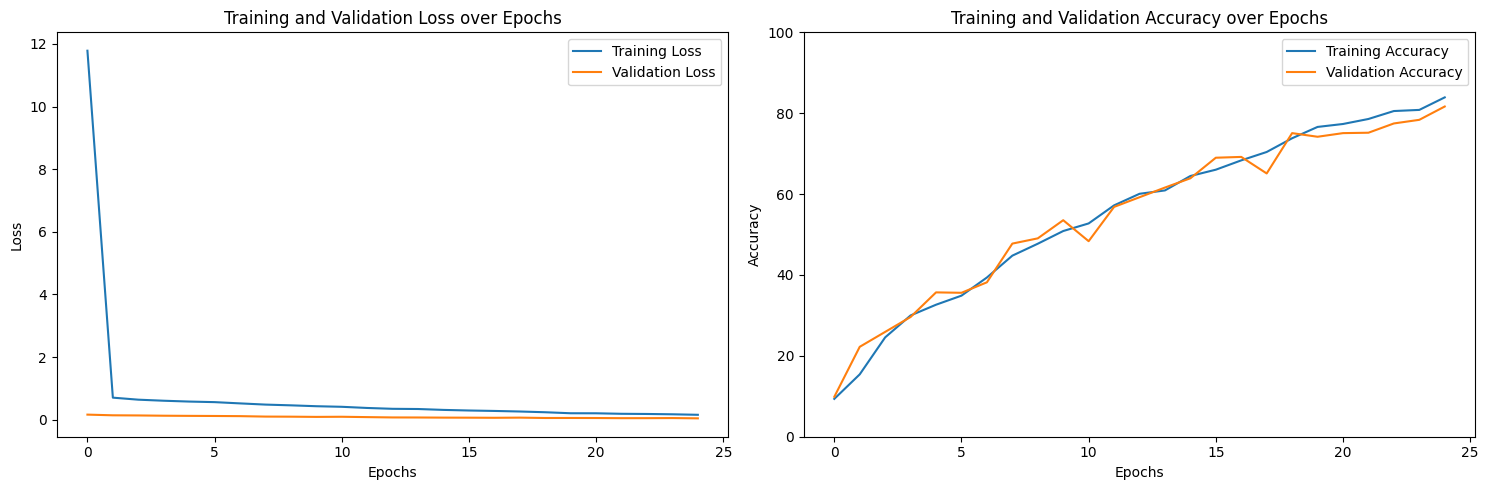

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()